# Selenium을 이용한 로그인 토큰 취득후 리퀘스츠로 크롤링

## 방식

- requests 만으로 크롤링 할 경우
    - 사이트마다의 방식이 너무나도 다름
    - 하나하나 get post를 분석해가며 알아내야함
    - 대신 속도가 매우 빠르고, 비동기 브라우징 또한 가능 -> 성능이 좋음

- selenium 만으로 크롤링 할 경우
    - 셀레늄 자체가 일상적인 브라우저를 기반으로 작동 -> 직관적임
    - 단, 매우 느리다는 문제점이 있음

- 테스트해볼 해결책
    - 웹사이트(서버)는 로그인을 할 경우 시간 제한이 있는 토큰을 발행
    - 셀레늄을 이용하여 로그인 
        - 해당 엑세스 토큰이 저장된 쿠키를 변수로 리퀘스츠에 반환
    - 반환 된 쿠키를 사용하여 requests로 로그인

## 모듈 임포트

In [2]:
from account import jp

In [3]:
import time
import requests
import re

import pandas as pd

from bs4 import BeautifulSoup

import selenium

from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

## 셀레늄을 통한 로그인
- 문주 코드임

In [5]:
############################
# 크롬으로 잡플래닛 사이트 열기
############################

service = Service(executable_path="./driver/chromedriver")

option = webdriver.ChromeOptions()
option.add_argument("headless")

browser = webdriver.Chrome(service=service, options=option)


url = r"https://www.jobplanet.co.kr/job"

browser.maximize_window()
print(browser.get_window_size())

browser.get(r"https://www.jobplanet.co.kr/job")

############################
# 잡플래닛에 로그인 하기
############################

# 로그인 버튼 찾기 및 클릭
login_btn = browser.find_element(By.CSS_SELECTOR,"a.btn_txt.login")
login_btn.click()

# 로그인 ID와 PW 쳐야할 곳 클릭 + 적기
login_Id = browser.find_element(By.CSS_SELECTOR, "#user_email")
login_Id.click()
login_Id.send_keys(jp.ID)

login_Pw = browser.find_element(By.CSS_SELECTOR, "#user_password")
login_Pw.click()
login_Pw.send_keys(jp.PW)

# 이메일로 로그인 버튼 누르기
em_log = browser.find_element(By.CSS_SELECTOR, "fieldset > button")
em_log.click()

WebDriverException: Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/google-chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)
Stacktrace:
#0 0x5624986eb4e3 <unknown>
#1 0x56249841ac76 <unknown>
#2 0x562498443d78 <unknown>
#3 0x562498440029 <unknown>
#4 0x56249847eccc <unknown>
#5 0x56249847e47f <unknown>
#6 0x562498475de3 <unknown>
#7 0x56249844b2dd <unknown>
#8 0x56249844c34e <unknown>
#9 0x5624986ab3e4 <unknown>
#10 0x5624986af3d7 <unknown>
#11 0x5624986b9b20 <unknown>
#12 0x5624986b0023 <unknown>
#13 0x56249867e1aa <unknown>
#14 0x5624986d46b8 <unknown>
#15 0x5624986d4847 <unknown>
#16 0x5624986e4243 <unknown>
#17 0x7f5635f4db43 <unknown>


## 엑세스 토큰이 저장된 쿠키 얻기

In [4]:
## get_cookies()로 쿠키 가져오기
cookies = browser.get_cookies()
## 쿠키를 딕셔너리로 만들기
cookies_dict = {}
for cookie in cookies:
    ## 각 쿠키의 name과 value를 딕셔너리로 저장
    cookies_dict[cookie['name']] = cookie['value']
## 확인을 위해 출력
# print(cookies_dict)       ## 쿠키 내용 해독시 민감한 정보가 포함되어 있음
## 브라우저 종료
browser.close()

## 쿠키를 이용하여 requests 세션 유지하기

- requestes의 세션 객체 생성 -> 헤더와 쿠키를 업데이트 해줌

In [5]:
session = requests.Session()
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}
## 기본 헤더와 쿠키 확인
print(session.headers)
print(session.cookies)

{'User-Agent': 'python-requests/2.30.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}
<RequestsCookieJar[]>


In [6]:
## 헤더와 쿠키를 업데이트
session.headers.update(headers)
session.cookies.update(cookies_dict)

## 업데이트한 헤더와 쿠키 확인
print(session.headers)
# print(session.cookies)        ## 쿠키 내용 해독시 민감한 정보가 포함되어 있음

{'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}


## 세션 객체를 통해 로그인이 잘 되는지 확인

In [30]:
## 삼성전자 리뷰 페이지로 이동
url = r'https://www.jobplanet.co.kr/companies/30139/reviews/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90'

- session 객체에서 requests 사용하듯 하면됨.

In [31]:
response = session.get(url)

## 응답 확인
print(response.status_code)

200


In [33]:
## 메인 컴에 lxml이 없어서 html.parser로 대체
soup = BeautifulSoup(response.text, 'html.parser')

## #viewReviewsList > div > div > div > section:nth-child(1) > div > div.ctbody_col2 > div > div.us_label_wrap > h2
## 리뷰 제목 하나 가져오기
soup.select_one('#viewReviewsList > div > div > div > section:nth-child(1) > div > div.ctbody_col2 > div > div.us_label_wrap > h2').text

'\nBEST\n      "망할리없음최근 반도체시장 침체로 좀 위험한듯 보였지만 걱정할 필요없음"\n    '

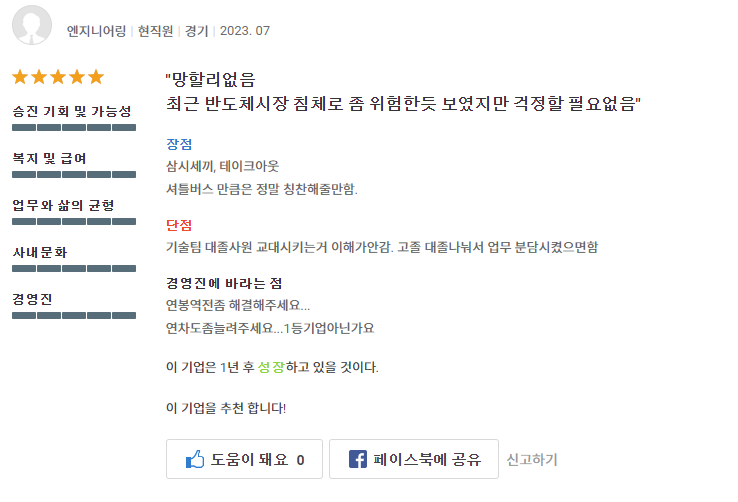

## 함수화 예)

In [35]:
# 추후 따로 모듈화 가능
############################
# 셀레늄으로 로그인 엑세스 토큰이 포함된 쿠키 반환 함수
############################
def get_login_cookies():
    ############################
    # 크롬으로 잡플래닛 사이트 열기
    ############################

    service = Service(executable_path="./driver/chromedriver.exe")
    browser = webdriver.Chrome(service=service)

    url = r"https://www.jobplanet.co.kr/job"

    browser.maximize_window()
    print(browser.get_window_size())

    browser.get(r"https://www.jobplanet.co.kr/job")

    ############################
    # 잡플래닛에 로그인 하기
    ############################

    # 로그인 버튼 찾기 및 클릭
    login_btn = browser.find_element(By.CSS_SELECTOR,"a.btn_txt.login")
    login_btn.click()

    # 로그인 ID와 PW 쳐야할 곳 클릭 + 적기
    login_Id = browser.find_element(By.CSS_SELECTOR, "#user_email")
    login_Id.click()
    login_Id.send_keys(jp.ID)

    login_Pw = browser.find_element(By.CSS_SELECTOR, "#user_password")
    login_Pw.click()
    login_Pw.send_keys(jp.PW)

    # 이메일로 로그인 버튼 누르기
    em_log = browser.find_element(By.CSS_SELECTOR, "fieldset > button")
    em_log.click()
    
    ############################
    # 쿠기 가져오기 -> 딕셔너리로 변환후 반환
    ############################
    ## get_cookies()로 쿠키 가져오기
    cookies = browser.get_cookies()
    ## 쿠키를 딕셔너리로 만들기
    cookies_dict = {}
    for cookie in cookies:
        ## 각 쿠키의 name과 value를 딕셔너리로 저장
        cookies_dict[cookie['name']] = cookie['value']
    ## 브라우저 종료
    browser.close()
    
    return cookies_dict

In [36]:
cookies_dict = get_login_cookies()

session = requests.Session()

session.headers.update(headers)
session.cookies.update(cookies_dict)

## 삼성전자 리뷰 페이지로 이동
res = session.get(url)

## 응답 확인
if res.status_code == 200:
    print("로그인 성공")
    
    review_title_1 = soup.select_one('#viewReviewsList > div > div > div > section:nth-child(1) > div > div.ctbody_col2 > div > div.us_label_wrap > h2').text

print(review_title_1)

{'width': 2576, 'height': 1408}
로그인 성공

BEST
      "망할리없음최근 반도체시장 침체로 좀 위험한듯 보였지만 걱정할 필요없음"
    
